In [3]:
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import wandb 
import os
api = wandb.Api()

In [4]:
artifacts = [
    "henry-scheible/plmbias/model-t5-small_stereoset_finetuned_ablation:v0"
]

In [11]:
data = {}
for artifact_name in artifacts:
    artifact = api.artifact(artifact_name)
    artifact_dir = artifact.download()
    with open(os.path.join(artifact_dir, "results.json"), "r") as res:
        data[artifact] = json.loads(res.read())
    data[artifact]["mask_shape"] = [24, 8]

wandb:   1 of 1 files downloaded.  


In [12]:
def generate_heatmap(checkpoint, contribs, mask_shape):
    sns.set(font_scale=1.2)
    matrix = np.flip(np.array(contribs).reshape(mask_shape))
    xticklabels = list(np.arange(matrix.shape[1]) + 1)
    yticklabels = list(matrix.shape[0] - np.arange(matrix.shape[0]))
    ax = plt.gca()
    sns.heatmap(matrix, ax=ax, cmap="PiYG", center=0, xticklabels=xticklabels, yticklabels=yticklabels, square=True, cbar=False)
    ax.set(
        xlabel="Head",
        ylabel="Layer"
    )
    model_name = checkpoint.split("/")[1]
    plt.savefig(f"results/{model_name}_heatmap.pdf", bbox_inches="tight", format="pdf")
    plt.show()

AttributeError: 'Artifact' object has no attribute 'split'

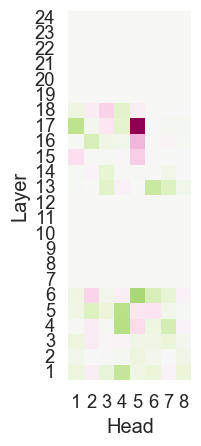

In [13]:
[generate_heatmap(checkpoint, result["contribs"], result["mask_shape"]) for checkpoint, result in data.items()]

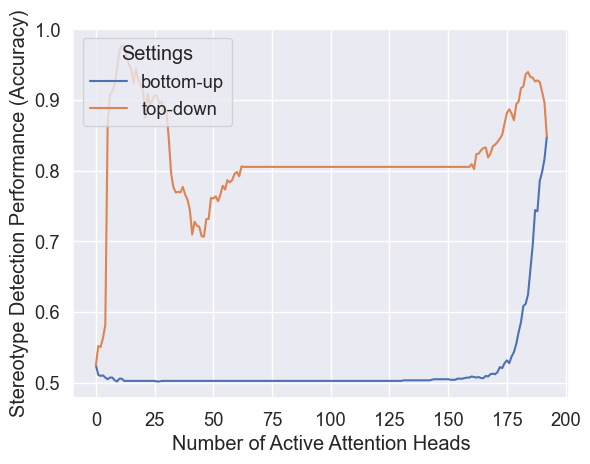

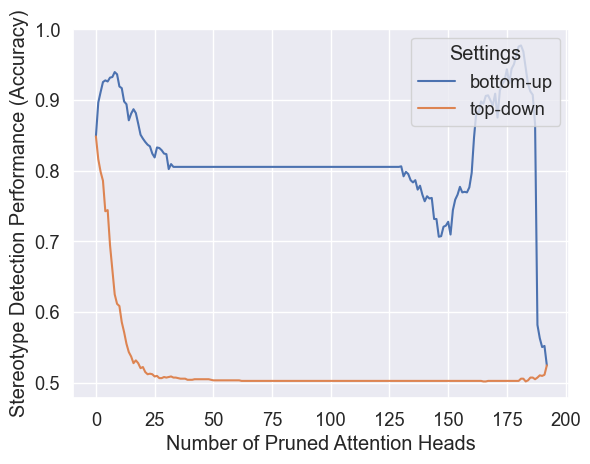

In [17]:
def generate_figure(checkpoint, results):
    sns.set(font_scale=1.2)
    df = pd.DataFrame({
        'heads': np.arange(len(results["contribs"]) + 1),
        'bottom-up': results["bottom_up_results"],
        'top-down': results["bottom_up_rev_results"],
    })
    melted_df = pd.melt(df, ['heads']).rename(columns={"variable": "Settings"})
    ax = sns.lineplot(x='heads', y='value', hue='Settings',
                data=melted_df)
    ax.set(xlabel="Number of Active Attention Heads", ylabel="Stereotype Detection Performance (Accuracy)")
    plt.legend(loc="upper left", title="Settings")
    # model_name = checkpoint.split("/")[1]
    # plt.savefig(f"results/{model_name}_add_ablation.pdf", format="pdf")
    plt.show()

    df = pd.DataFrame({
        'heads': np.arange(len(results["contribs"])+1),
        'bottom-up': results["top_down_results"],
        'top-down': results["top_down_rev_results"],
    })
    melted_df = pd.melt(df, ['heads']).rename(columns={"variable": "Settings"})
    ax = sns.lineplot(x='heads', y='value', hue='Settings',
                data=melted_df)
    ax.set(xlabel="Number of Pruned Attention Heads", ylabel="Stereotype Detection Performance (Accuracy)")
    plt.legend(loc="upper right", title="Settings")
    # model_name = checkpoint.split("/")[1]
    # plt.savefig(f"results/{model_name}_remove_ablation.pdf", format="pdf")
    plt.show()


for checkpoint, results in data.items():
    generate_figure(checkpoint, results)